# Image segmentation using fast.ai

**WARNING**: You are entering the experimental zone.

We will use the fastai library (https://github.com/fastai/fastai) to create and train a segmentation algorithm. Note that fastai also requires python 3.7. 

I am using a different conda environment for the fastai part compared to all the other work (e.g. keras-retinanet).

We already prepared the mask data in the `create-segmentation-masks` notebook.

Here we will load the data, train a segmentation algorithm, visualize the predictions.

Further we will create predictions for the entire world.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [34]:
from pyclouds.imports import *

In [3]:
# For use with multiple GPUs
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
# Necessary for some reason to have pandas work properly. Probably version mismatch...
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

In [5]:
from fastai.vision import *
from fastai.callbacks.hooks import *

In [6]:
IMGDIR = '/local/S.Rasp/cloud-classification/'

In [7]:
img_size = np.array((1400, 2100)) # Pytorch convention

In [8]:
work_size = img_size // 3; work_size

array([466, 700])

In [9]:
batch_size = 6

In [10]:
classes_bg = ['Background'] + classes

In [11]:
cl2id = {c: i for i, c in enumerate(classes_bg)}

## Load datasets

For now this is necessary even if you are only loading a model that has already been trained.

In [12]:
df = pd.read_csv(IMGDIR + 'fastai.csv', index_col=0); df.head()

fn  \
0  Region1_MAM_Aqua/Aqua_CorrectedReflectance2007...   
1  Region3_DJF_Aqua/Aqua_CorrectedReflectance2015...   
2  Region3_SON_Terra/Terra_CorrectedReflectance20...   
3  Region1_DJF_Aqua/Aqua_CorrectedReflectance2011...   
4  Region1_DJF_Aqua/Aqua_CorrectedReflectance2011...   

                                                mask  
0  masks/Region1_MAM_Aqua/Aqua_CorrectedReflectan...  
1  masks/Region3_DJF_Aqua/Aqua_CorrectedReflectan...  
2  masks/Region3_SON_Terra/Terra_CorrectedReflect...  
3  masks/Region1_DJF_Aqua/Aqua_CorrectedReflectan...  
4  masks/Region1_DJF_Aqua/Aqua_CorrectedReflectan...

In [13]:
len(df)

30236

In [14]:
# For fast ai the masks column needs absolute paths. Let's add them
df['mask'] = df['mask'].apply(lambda fn: IMGDIR + fn); df.head()

fn  \
0  Region1_MAM_Aqua/Aqua_CorrectedReflectance2007...   
1  Region3_DJF_Aqua/Aqua_CorrectedReflectance2015...   
2  Region3_SON_Terra/Terra_CorrectedReflectance20...   
3  Region1_DJF_Aqua/Aqua_CorrectedReflectance2011...   
4  Region1_DJF_Aqua/Aqua_CorrectedReflectance2011...   

                                                mask  
0  /local/S.Rasp/cloud-classification/masks/Regio...  
1  /local/S.Rasp/cloud-classification/masks/Regio...  
2  /local/S.Rasp/cloud-classification/masks/Regio...  
3  /local/S.Rasp/cloud-classification/masks/Regio...  
4  /local/S.Rasp/cloud-classification/masks/Regio...

In [15]:
# Create the fastai dataset
src = SegmentationItemList.from_df(df, path=IMGDIR); src

SegmentationItemList (30236 items)
[Image (3, 1400, 2100), Image (3, 1400, 2100), Image (3, 1400, 2100), Image (3, 1400, 2100), Image (3, 1400, 2100)]...
Path: /local/S.Rasp/cloud-classification

In [16]:
# Split by Region
src = src.split_by_valid_func(lambda fn: 'Region2' in fn); src

ItemLists;

Train: SegmentationItemList (24206 items)
[Image (3, 1400, 2100), Image (3, 1400, 2100), Image (3, 1400, 2100), Image (3, 1400, 2100), Image (3, 1400, 2100)]...
Path: /local/S.Rasp/cloud-classification;

Valid: SegmentationItemList (6030 items)
[Image (3, 1400, 2100), Image (3, 1400, 2100), Image (3, 1400, 2100), Image (3, 1400, 2100), Image (3, 1400, 2100)]...
Path: /local/S.Rasp/cloud-classification;

Test: None

In [17]:
src = src.label_from_df('mask', classes=classes_bg); src

LabelLists;

Train: LabelList
y: SegmentationLabelList (24206 items)
[ImageSegment (1, 1400, 2100), ImageSegment (1, 1400, 2100), ImageSegment (1, 1400, 2100), ImageSegment (1, 1400, 2100), ImageSegment (1, 1400, 2100)]...
Path: /local/S.Rasp/cloud-classification
x: SegmentationItemList (24206 items)
[Image (3, 1400, 2100), Image (3, 1400, 2100), Image (3, 1400, 2100), Image (3, 1400, 2100), Image (3, 1400, 2100)]...
Path: /local/S.Rasp/cloud-classification;

Valid: LabelList
y: SegmentationLabelList (6030 items)
[ImageSegment (1, 1400, 2100), ImageSegment (1, 1400, 2100), ImageSegment (1, 1400, 2100), ImageSegment (1, 1400, 2100), ImageSegment (1, 1400, 2100)]...
Path: /local/S.Rasp/cloud-classification
x: SegmentationItemList (6030 items)
[Image (3, 1400, 2100), Image (3, 1400, 2100), Image (3, 1400, 2100), Image (3, 1400, 2100), Image (3, 1400, 2100)]...
Path: /local/S.Rasp/cloud-classification;

Test: None

In [18]:
data = src.transform(get_transforms(), size=work_size, tfm_y=True); data

LabelLists;

Train: LabelList
y: SegmentationLabelList (24206 items)
[ImageSegment (1, 1400, 2100), ImageSegment (1, 1400, 2100), ImageSegment (1, 1400, 2100), ImageSegment (1, 1400, 2100), ImageSegment (1, 1400, 2100)]...
Path: /local/S.Rasp/cloud-classification
x: SegmentationItemList (24206 items)
[Image (3, 1400, 2100), Image (3, 1400, 2100), Image (3, 1400, 2100), Image (3, 1400, 2100), Image (3, 1400, 2100)]...
Path: /local/S.Rasp/cloud-classification;

Valid: LabelList
y: SegmentationLabelList (6030 items)
[ImageSegment (1, 1400, 2100), ImageSegment (1, 1400, 2100), ImageSegment (1, 1400, 2100), ImageSegment (1, 1400, 2100), ImageSegment (1, 1400, 2100)]...
Path: /local/S.Rasp/cloud-classification
x: SegmentationItemList (6030 items)
[Image (3, 1400, 2100), Image (3, 1400, 2100), Image (3, 1400, 2100), Image (3, 1400, 2100), Image (3, 1400, 2100)]...
Path: /local/S.Rasp/cloud-classification;

Test: None

In [19]:
data = data.databunch(bs=batch_size)

In [20]:
data = data.normalize(imagenet_stats)

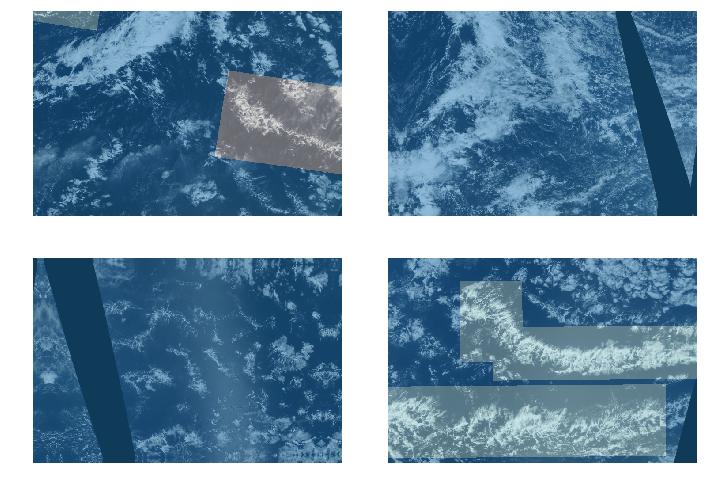

In [21]:
data.show_batch(2, figsize=(10,7))

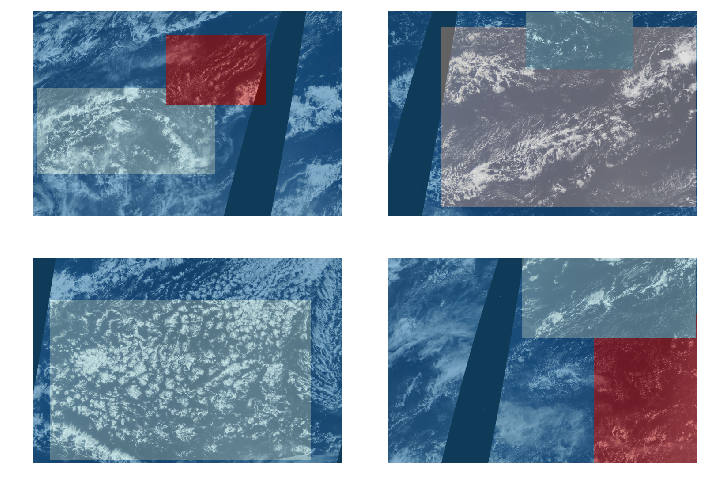

In [22]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

In [23]:
x, y = next(iter(data.valid_dl))

In [24]:
x.size(), y.size()

(torch.Size([6, 3, 466, 700]), torch.Size([6, 1, 466, 700]))

## Build the model

In [25]:
void_code = cl2id['Background']; void_code

0

In [26]:
# Define accuracy metric
def pixel_acc(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [27]:
wd=1e-2 

In [28]:
# use a small resnet as backbone with pretrained imagenet weights
learn = unet_learner(data, models.resnet18, metrics=pixel_acc, wd=wd, pretrained=True)

In [29]:
learn.loss_func 

FlattenedLoss of CrossEntropyLoss()

## Train the model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


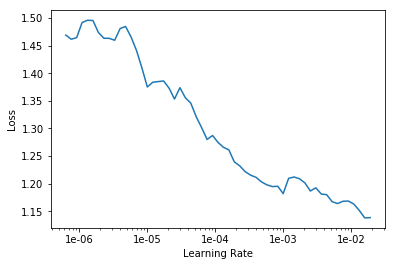

In [30]:
lr_find(learn)
learn.recorder.plot()

In [31]:
lr = 1e-4

In [32]:
learn.fit_one_cycle(1, max_lr=lr, wd=wd)

In [33]:
learn.save('full_third_ep1')

In [34]:
learn.unfreeze()

In [35]:
lrs = slice(1e-4/100, 1e-4/10)

In [36]:
learn.fit_one_cycle(1, max_lr=lrs, wd=wd)

In [37]:
learn.save('full_third_ep2')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


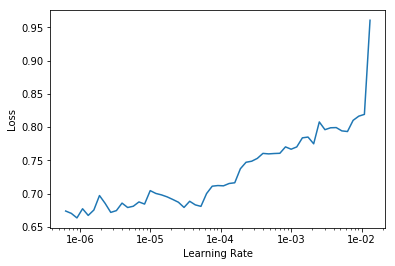

In [39]:
learn.lr_find()
learn.recorder.plot()

In [40]:
lrs = slice(1e-6/100, 1e-6/10)

In [41]:
learn.fit_one_cycle(1, max_lr=lrs, wd=wd)

In [42]:
learn.save('full_third_ep3')

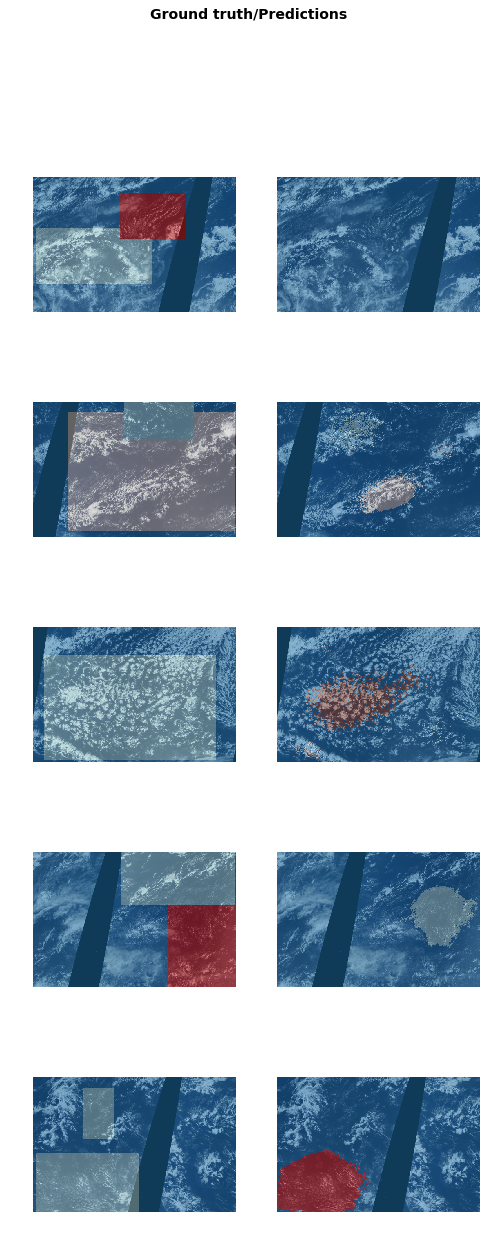

In [38]:
learn.show_results()

## Load the trained model

In [21]:
learn = unet_learner(data, models.resnet18, wd=1e-2, pretrained=True)

In [22]:
learn.load('full_third_ep2') # using ep two because the validation accuracy is slightly higher

Learner(data=ImageDataBunch;

Train: LabelList
y: SegmentationLabelList (24206 items)
[ImageSegment (1, 1400, 2100), ImageSegment (1, 1400, 2100), ImageSegment (1, 1400, 2100), ImageSegment (1, 1400, 2100), ImageSegment (1, 1400, 2100)]...
Path: /local/S.Rasp/cloud-classification
x: SegmentationItemList (24206 items)
[Image (3, 1400, 2100), Image (3, 1400, 2100), Image (3, 1400, 2100), Image (3, 1400, 2100), Image (3, 1400, 2100)]...
Path: /local/S.Rasp/cloud-classification;

Valid: LabelList
y: SegmentationLabelList (6030 items)
[ImageSegment (1, 1400, 2100), ImageSegment (1, 1400, 2100), ImageSegment (1, 1400, 2100), ImageSegment (1, 1400, 2100), ImageSegment (1, 1400, 2100)]...
Path: /local/S.Rasp/cloud-classification
x: SegmentationItemList (6030 items)
[Image (3, 1400, 2100), Image (3, 1400, 2100), Image (3, 1400, 2100), Image (3, 1400, 2100), Image (3, 1400, 2100)]...
Path: /local/S.Rasp/cloud-classification;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequen

## Visualize model predictions

In [24]:
from scipy.ndimage import gaussian_filter

In [25]:
def get_pred(img):
    pred = learn.predict(img)[2]
    return pred.numpy()

In [26]:
def plot_probs(pred):
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    for i, ax in enumerate(axs.flatten()[:5]):
        ax.matshow(pred[i], vmin=0, vmax=1)
        ax.set_title(classes_bg[i])
    plt.tight_layout()

In [27]:
def get_max_class(p, thresh=0.3, smooth=None):
    x = p.copy()
    if smooth is not None:
        for i in range(x.shape[0]):
            x[i] = gaussian_filter(x[i], smooth)
    x[0][np.max(x[1:], 0) > thresh] = 0
    return np.argmax(x, 0)

In [28]:
def plot_mask_over_img(img, mask):
    fig = plt.figure(figsize=(10,10))
    plt.imshow(np.rollaxis(img.data.numpy(), 0,3))
    plt.imshow(mask, alpha=0.2)

In [29]:
img, mask = data.valid_ds[8]

In [30]:
pred = get_pred(img)

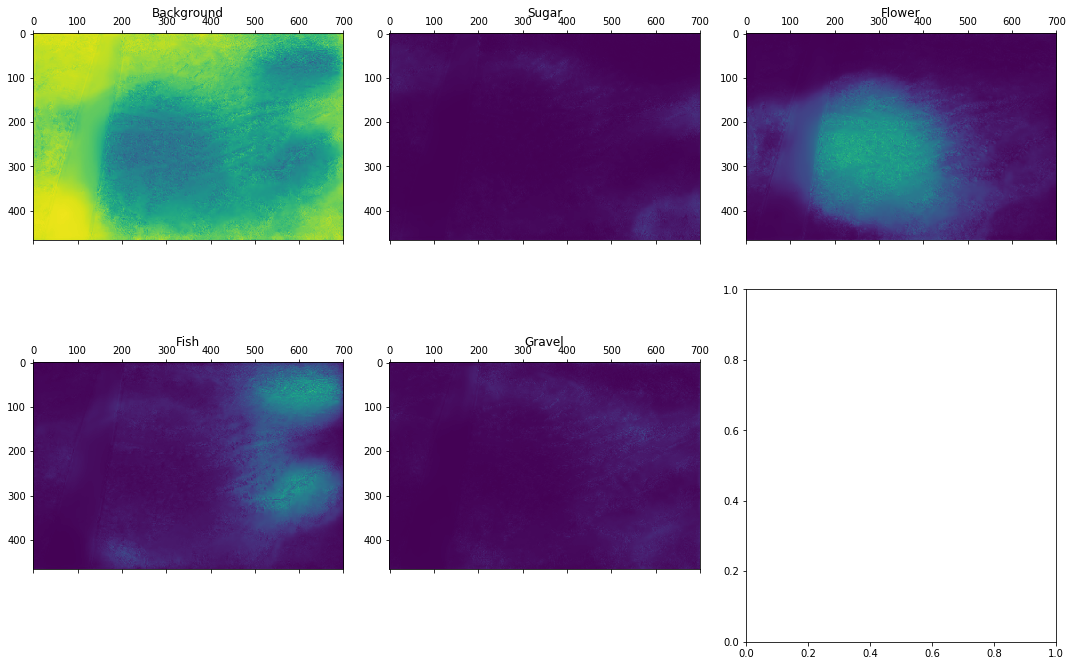

In [31]:
plot_probs(pred)

In [32]:
pred_mask = get_max_class(pred, 0.3, 10)

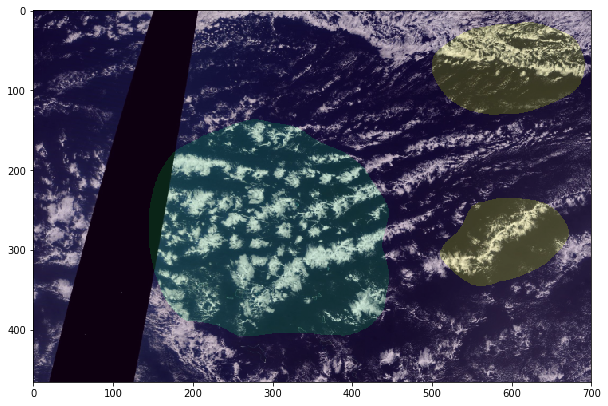

In [33]:
plot_mask_over_img(img, pred_mask)

## Create predictions for the entire world

First we need to download the dataset. Because Worldview doesn't allow large file downloads we download the Northern and Southern hemisphere separately. Note that we are also halving the resolution. Which doesn't matter because we use one third of the raw resolution for the algorithm anyway

```
python image_download.py --year_range [2017,2018] --months [1,2,3,4,5,6,7,8,9,10,11,12] --lon_range [-180,180] --lat_range [-90,0] --save_path /project/meteo/work/S.Rasp/cloud-classification/world/ --satellite Aqua --deg2pix 50

python image_download.py --year_range [2017,2018] --months [1,2,3,4,5,6,7,8,9,10,11,12] --lon_range [-180,180] --lat_range [0,90] --save_path /project/meteo/work/S.Rasp/cloud-classification/world/ --satellite Aqua --deg2pix 50``
```

Next we need to concatenate the images. Takes like half an hour.
```
world_fns = sorted(glob('/project/meteo/work/S.Rasp/cloud-classification/world/*_0-90*'))
for fn in world_fns:
    fn2 = fn[:-9] + '-90-0.jpeg'
    fn_out = fn[:-9] + '-90-90.jpeg'
    !convert $fn $fn2 -append $fn_out
```

In [48]:
world_fns = sorted(glob('/project/meteo/work/S.Rasp/cloud-classification/world/*_-90-90*')) 

In [49]:
len(world_fns)

365

In [65]:
def get_preds_from_fn(fn, learn, deg2pix, dx = 466, dy = 700, noprog=False):
    """
    Essentially tiles together predictions for a larger image. Takes the lowest bg probability for overlapping 
    regions. This is to avoid edge effects.
    """
    img = open_image(fn)
    raw_img_size = np.array(img.size)
    if not noprog: print(f'raw_img_size = {raw_img_size}')
    world_size = (np.array(raw_img_size) // 3 * (100 / deg2pix)).astype(int)
    if not noprog: print(f'world_size = {world_size}')
    img = img.apply_tfms(
        [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True)]*2, 
        size = world_size
    )
    
    nx = world_size[0] // dx
    ny = world_size[1] // dy
    if not noprog: print(f'nx, ny = {nx, ny}')
    
    raw_img = deepcopy(img)
    raw_px = img._px
    raw_px = raw_px[:, :nx*dx, :ny*dy]
    
    tot_pred = np.zeros([5, nx*dx, ny*dy])
    tot_pred[0] = 1
    
    for i in tqdm(np.arange(0, nx*dx, dx//2)[:-1], disable=noprog):
        for j in np.arange(0, ny*dy, dy//2)[:-1]:
            img._px = raw_px[:, i:i+dx, j:j+dy]
            pred = get_pred(img)

            lowest_bg = pred[0] < tot_pred[0, i:i+dx, j:j+dy]

            for ic in range(len(classes_bg)):
                tot_pred[ic, i:i+dx, j:j+dy] = np.where(lowest_bg, pred[ic], tot_pred[ic, i:i+dx, j:j+dy])
    
    img._px = raw_px
    
    return tot_pred, img

In [44]:
from scipy.ndimage import zoom

In [45]:
def plot_mask_over_img(img, mask, z=1, save=None, contour=False):
    fig, ax = plt.subplots(1, 1, figsize=(25,25))
    
    img_data = np.rollaxis(img.data.numpy(), 0,3)
    orig_shape = np.array(pred_mask.shape)
    img_re = zoom(img_data, (z, z, 1)) if z !=0 else img_data
    mask_re = zoom(mask, (z, z)) if z !=0 else mask
    ax.imshow(img_re)
    ax.set_xticks([]); ax.set_yticks([])
    for i, c in enumerate(classes):
        a = mask_re == i+1
        if contour:
            ax.contour(a, levels=[0.5], colors=[np.array(l2c[c]) / 255], linewidths=[5])
        else:
            plt.imshow(a, alpha=0.5, cmap = mpl.colors.ListedColormap(['none', np.array(l2c[c]) / 255]))
        
    if save is not None:
        fig.savefig(save, bbox_inches='tight', pad_inches=0., dpi=200)

In [38]:
tot_pred, img = get_preds_from_fn(world_fns[0], learn, 50)

raw_img_size = [ 9000 18000]
world_size = [ 6000 12000]
nx, ny = (12, 17)


In [39]:
pred_mask = get_max_class(tot_pred, 0.3, 10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


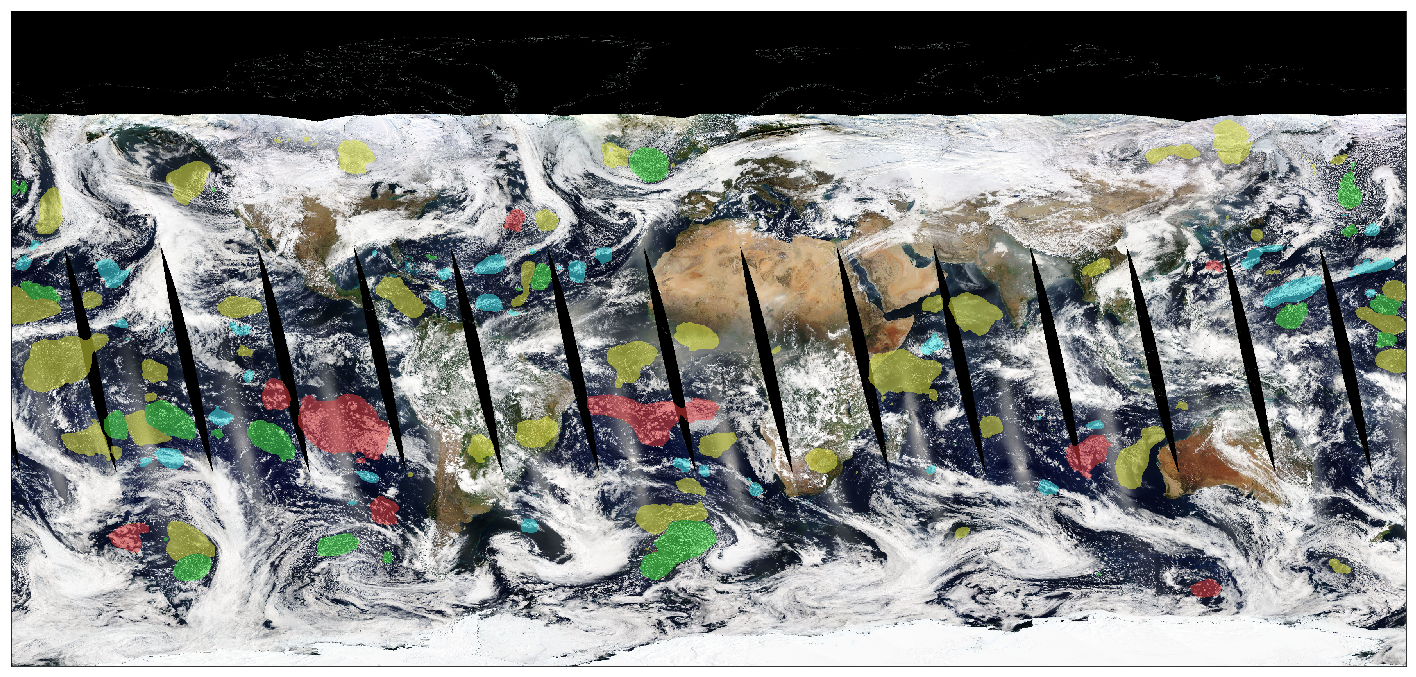

In [46]:
plot_mask_over_img(img, pred_mask, 0.3)

## Loop over an entire year of data

This simple implementation takes quite a while. Approximately 5 mins for the entire workflow. So one year will take a while. Many options for improvements though (e.g. several image patches in one batch, multi-processing...)

In [62]:
world_fns[151]

'/project/meteo/work/S.Rasp/cloud-classification/world/Aqua_CorrectedReflectance20170601_-180-180_-90-90.jpeg'

In [ ]:
%%time
for fn in tqdm(world_fns[151:]):
    date = fn[-29:-21]
    tot_pred, img = get_preds_from_fn(fn, learn, 50, noprog=True)
    pred_mask = get_max_class(tot_pred, 0.3, 10)
    plot_mask_over_img(img, pred_mask, 0.3, f'/project/meteo/work/S.Rasp/cloud-classification/ml/world_{date}.png')
    np.save(f'/project/meteo/work/S.Rasp/cloud-classification/ml/world_prob_{date}.npy', tot_pred)
    np.save(f'/project/meteo/work/S.Rasp/cloud-classification/ml/world_mask_{date}.npy', pred_mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Now we can create a gif from the saved images:

```
convert -delay 120 -loop 0 world_2017010* animation.gif
```

## Create a climatology

Load the masks for one year and create plots

In [50]:
mask_fns = sorted(glob('/project/meteo/work/S.Rasp/cloud-classification/ml/world_mask*'))

In [51]:
len(mask_fns)

151

In [52]:
m = np.load(mask_fns[0])
mean_mask = np.zeros((4, *m.shape)); mean_mask.shape

(4, 5592, 11900)

In [53]:
for mfn in tqdm(mask_fns):
    m = np.load(mfn)
    for i in range(4):
        mean_mask[i] += m == i+1

In [60]:
# Relative frequency
mean_mask /= len(mask_fns)

In [54]:
import cartopy.crs as ccrs

In [56]:
world_size = [ 6000, 12000]
world_size, img.size

([6000, 12000], torch.Size([5592, 11900]))

In [57]:
# Shoddy way to figure out lats and lons for image.
lons = np.linspace(-180,180,12000)
lats = np.linspace(90,-90,6000)
lons = lons[:11900]
lats = lats[-5592:]
max_lon, min_lat = lons[-1], lats[0]; max_lon, min_lat

(176.9997499791649, 77.75795965994332)

In [58]:
def plot_heatmap(mask, z=0.3, figsize=(10,10), save=None, title='', cblabel='',
                 levels=np.arange(0.05, 0.85, 0.05)):
    z = 0.3
    mask_re = zoom(mask, (z, z))
    nlat, nlon = mask_re.shape
    lons = np.linspace(-180,max_lon,nlon)
    lats = np.linspace(90,-min_lat,nlat)
    
    fig = plt.figure(figsize = (10, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    plt.contourf(lons, lats, mask_re, transform=ccrs.PlateCarree(), cmap='gnuplot2_r', 
                 levels=levels, extend='both')
    ax.coastlines()
    plt.title(title)
    cb = plt.colorbar(orientation='horizontal', pad=0.01, extend='both', shrink=0.7)
    cb.ax.set_xlabel(cblabel)
    plt.tight_layout()

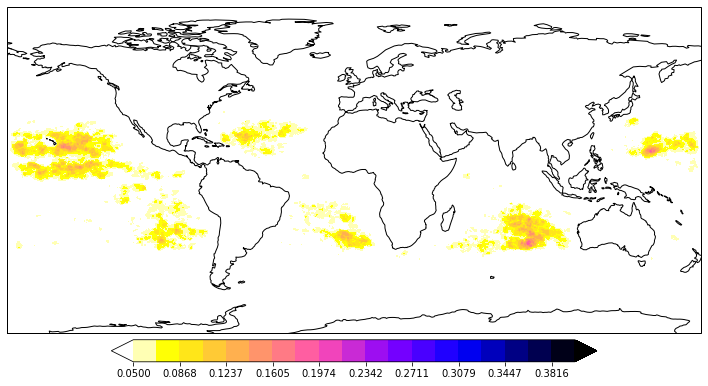

In [61]:
plot_heatmap(mean_mask[2], levels=np.linspace(0.05, 0.4, 20))